# Melanoma Detection

This is an attempt to differentiate between three types of skin lesions, melanoma, nevi and seborrheic keratosesone. Melanoma is cancerous; the other three are benign.

The data and objective are from the [ISIC 2017: Skin Lesion Analysis Towards Melanoma Detection](https://challenge.kitware.com/#challenge/583f126bcad3a51cc66c8d9a)


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import accuracy
from functools import partial

In [3]:
np.random.seed(303)

## Load and view data

In [4]:
datapath = Path('../data').resolve() # absolute path to data
!ls $datapath

HAM10000_metadata.csv  hmnist_28_28_RGB.csv  hmnist_8_8_RGB.csv  models
hmnist_28_28_L.csv     hmnist_8_8_L.csv      images


In [5]:
bs=64

In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
getbunch = partial(
    ImageDataBunch.from_csv,
    datapath,
    folder='images', 
    csv_labels='HAM10000_metadata.csv',
    valid_pct=0.2,
    fn_col=1, 
    label_col=2, 
    suffix='.jpg',
    ds_tfms=tfms,
    bs=bs,
    size=64
)

In [8]:
data = getbunch().normalize(imagenet_stats)

In [9]:
data.classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

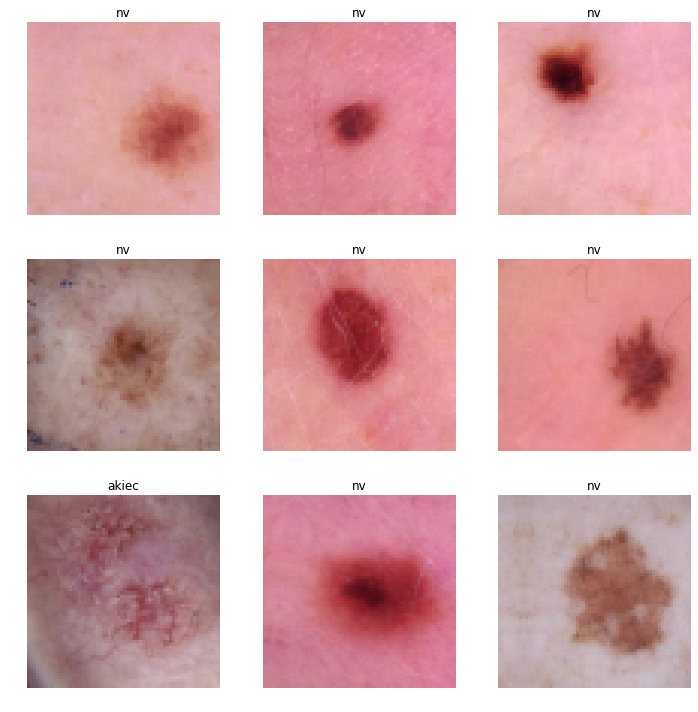

In [10]:
data.show_batch(rows=3, figsize=(10, 10))

In [11]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


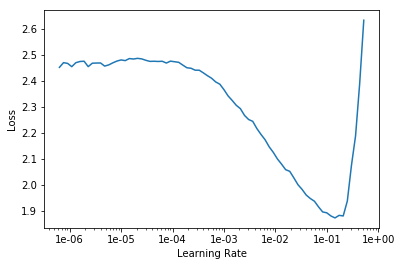

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
lr = 6e-3

In [14]:
learn.fit_one_cycle(6, lr)

epoch,train_loss,valid_loss,accuracy
1,1.165570,0.772792,0.744883
2,0.774072,0.600169,0.769845
3,0.668334,0.591066,0.771842
4,0.618517,0.539449,0.794808
5,0.534450,0.489578,0.809785
6,0.515663,0.479088,0.815277


In [16]:
learn.save('res50-64-frozen')

In [22]:
# _ = learn.load('res50-64-frozen')

In [23]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


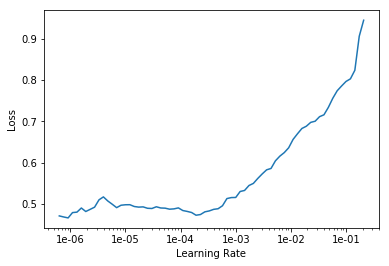

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(6, slice(3e-5, lr / 5))

epoch,train_loss,valid_loss,accuracy
1,0.516317,0.463615,0.829256
2,0.548336,0.491585,0.821268
3,0.522148,0.487584,0.825761
4,0.486042,0.459322,0.831253
5,0.426701,0.421100,0.849226
6,0.381800,0.408443,0.859211


In [26]:
learn.save('res50-64-unfrozen')

In [27]:
# _ = learn.load('res50-64-unfrozen')

In [30]:
data = getbunch(size=128).normalize(imagenet_stats)

In [31]:
learn.data = data
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


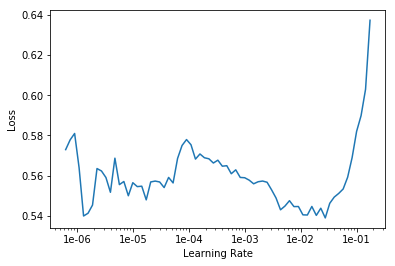

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
lr2 = 2e-3

In [34]:
learn.fit_one_cycle(6, lr2)

epoch,train_loss,valid_loss,accuracy
1,0.483614,0.423083,0.847229
2,0.455891,0.412501,0.846231
3,0.435332,0.407257,0.853719
4,0.383127,0.386255,0.855716
5,0.355455,0.365040,0.875187
6,0.350310,0.363968,0.868697


In [35]:
learn.save('res50-128-frozen')

In [37]:
# _ = learn.load('res50-128-frozen')

In [38]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


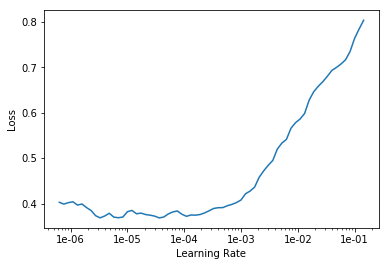

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(6, slice(4e-6, lr2 / 5))

epoch,train_loss,valid_loss,accuracy
1,0.339737,0.357466,0.871692
2,0.353385,0.380046,0.860210
3,0.339364,0.361893,0.868697
4,0.316420,0.353648,0.873190
5,0.274683,0.357294,0.873689
6,0.258413,0.349454,0.875187


In [41]:
learn.save('res50-128-unfrozen')

In [48]:
# _ = learn.load('res50-128-unfrozen')

In [49]:
data = getbunch(size=256, bs=bs // 2).normalize(imagenet_stats)

In [50]:
learn.data = data
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


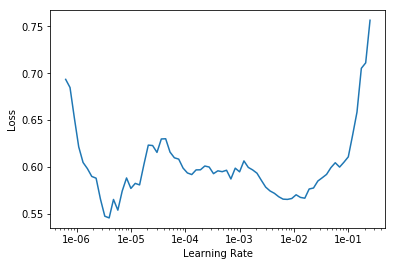

In [51]:
learn.lr_find()
learn.recorder.plot()

In [52]:
lr3 = 1e-3

In [53]:
learn.fit_one_cycle(6, lr3)

epoch,train_loss,valid_loss,accuracy
1,0.495440,0.389541,0.846730
2,0.421535,0.387283,0.853719
3,0.429001,0.371614,0.864703
4,0.375946,0.335889,0.873689
5,0.344936,0.317345,0.874688
6,0.356398,0.321417,0.878183


In [54]:
learn.save('res50-256-frozen')

In [55]:
# _ = learn.load('res50-256-unfrozen')

In [56]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


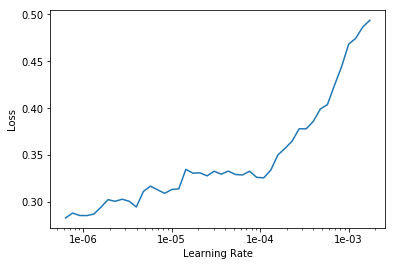

In [57]:
learn.lr_find()
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(6, slice(1e-6, lr3 / 5))

epoch,train_loss,valid_loss,accuracy
1,0.323654,0.317407,0.875187
2,0.362843,0.325445,0.877184
3,0.346474,0.318212,0.874189
4,0.316044,0.309731,0.880180
5,0.304654,0.307298,0.884174
6,0.298562,0.306509,0.883675


In [60]:
learn.save('res50-256-unfrozen')

In [61]:
# _ = learn.load('res50-256-unfrozen')

In [62]:
interp = ClassificationInterpretation.from_learner(learn)

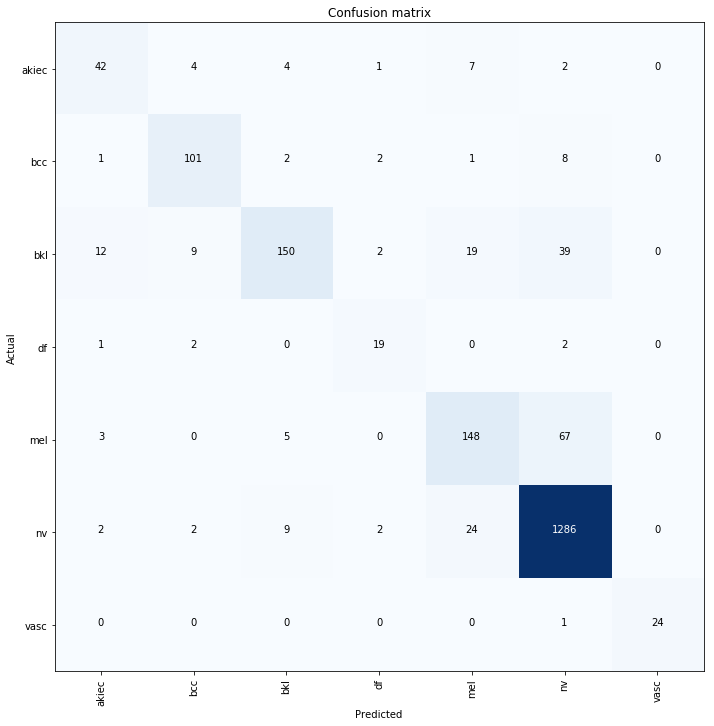

In [63]:
interp.plot_confusion_matrix(figsize=(10,10))